In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from deepmip_dict import deepmip_dict

data_dir = '/Users/wb19586/Documents/coding_github/aprp_deepmip/ebm_output_data/'


In [5]:
# define functions
def select_area(da,min_lat,max_lat, lat_name='lat'):
    # Check if the latitude dimension is monotonically increasing or decreasing
    if da[lat_name].values[0] < da[lat_name].values[-1]:
        # Latitude is increasing
        return da.sel(lat=slice(min_lat, max_lat))
    else:
        # Latitude is decreasing
        return da.sel(lat=slice(max_lat, min_lat))


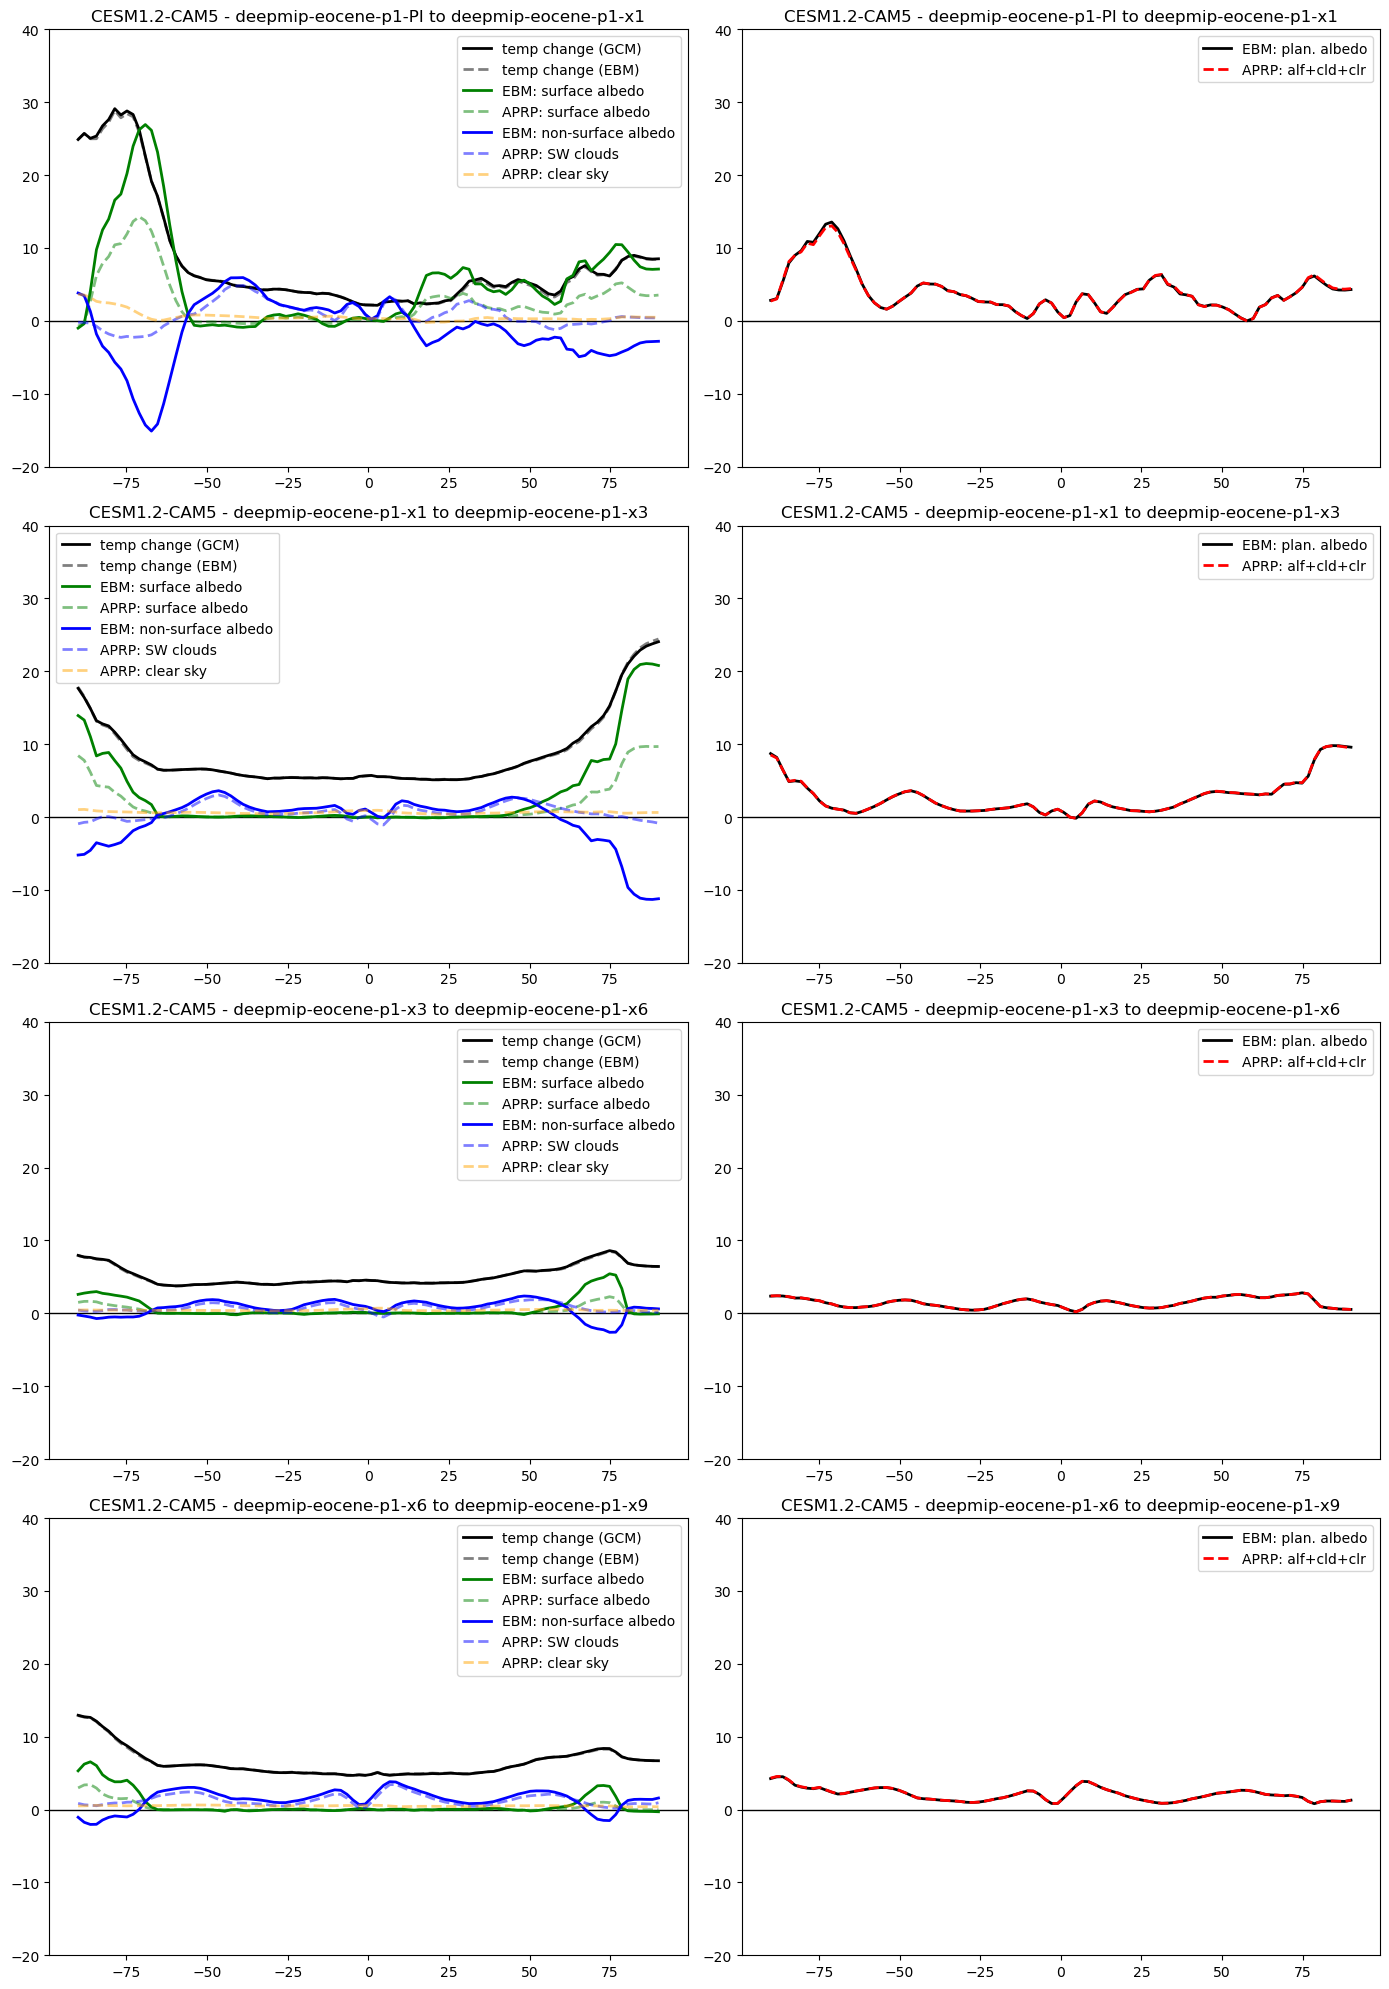

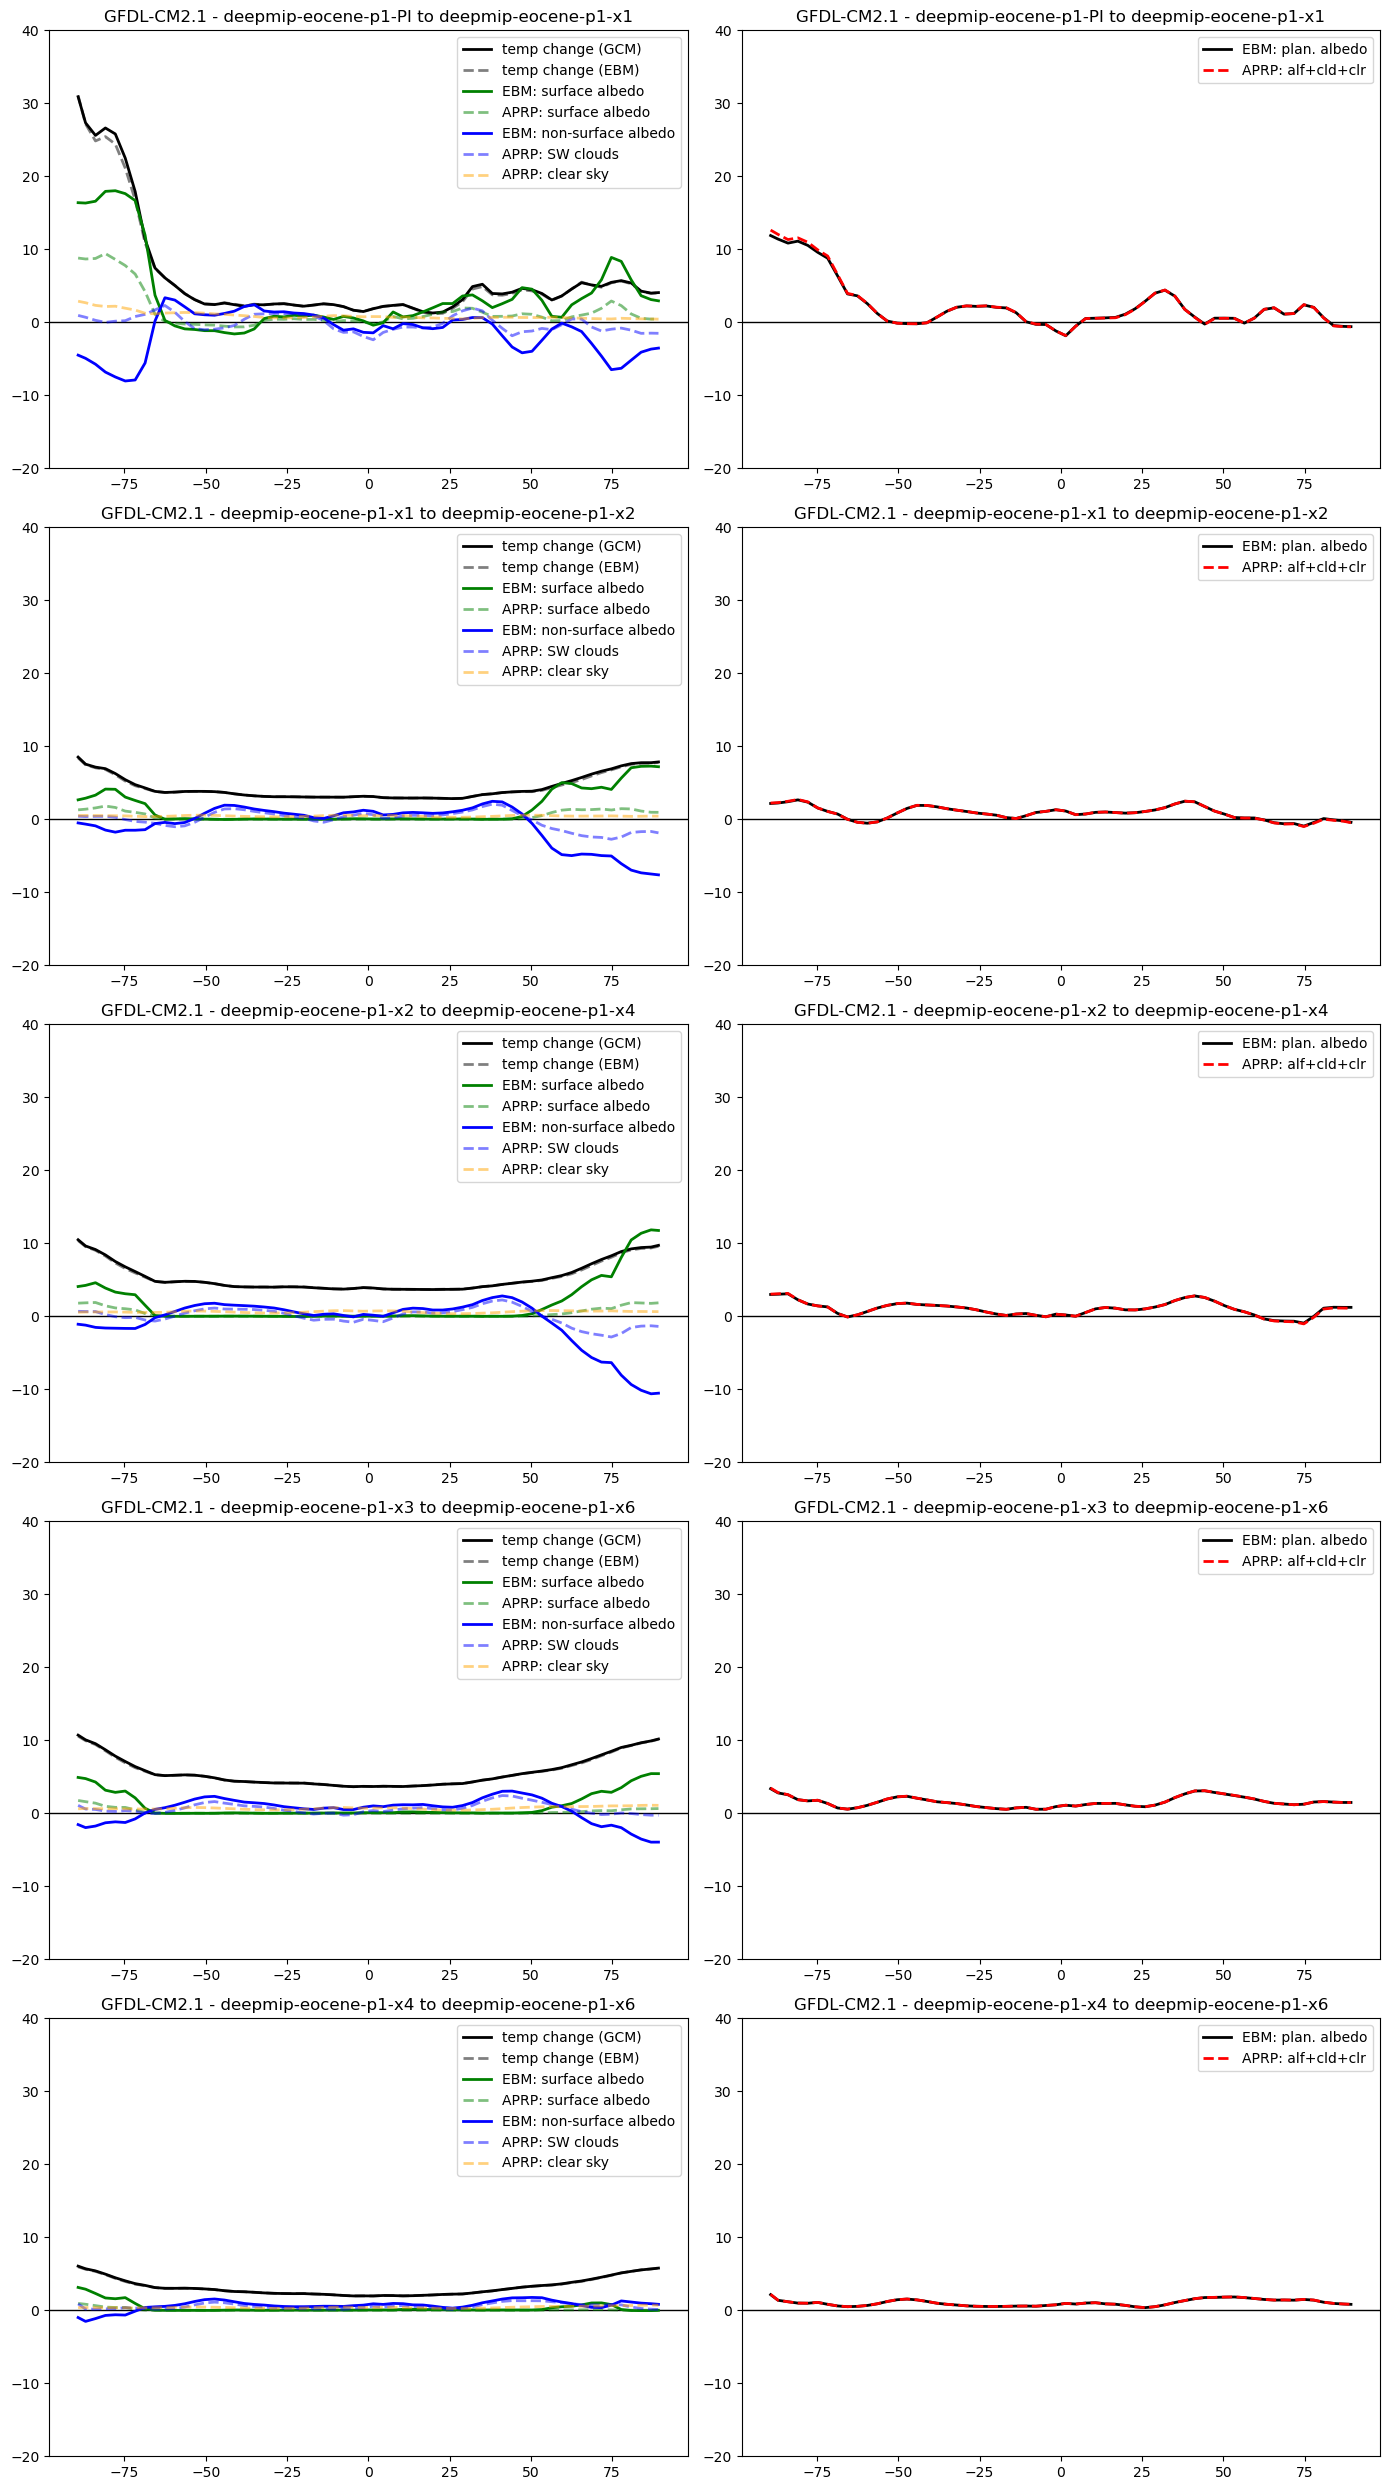

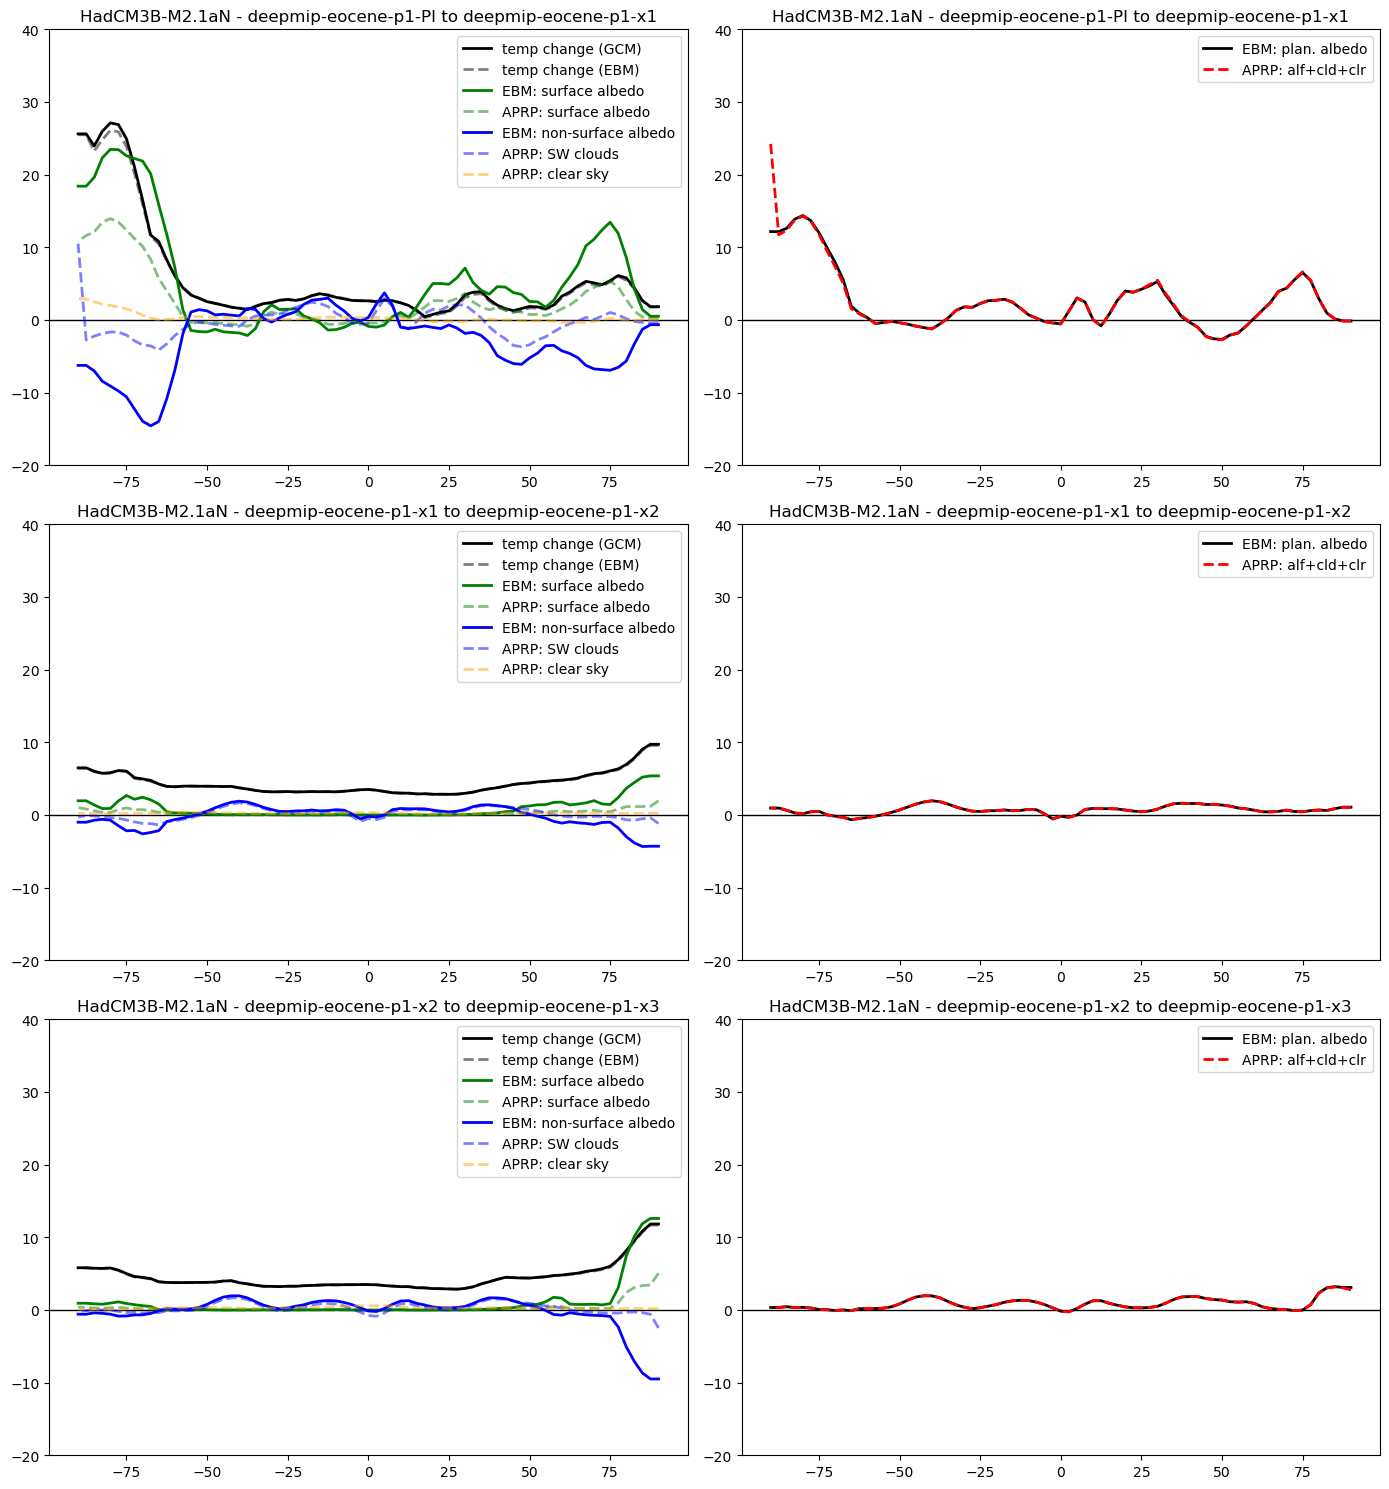

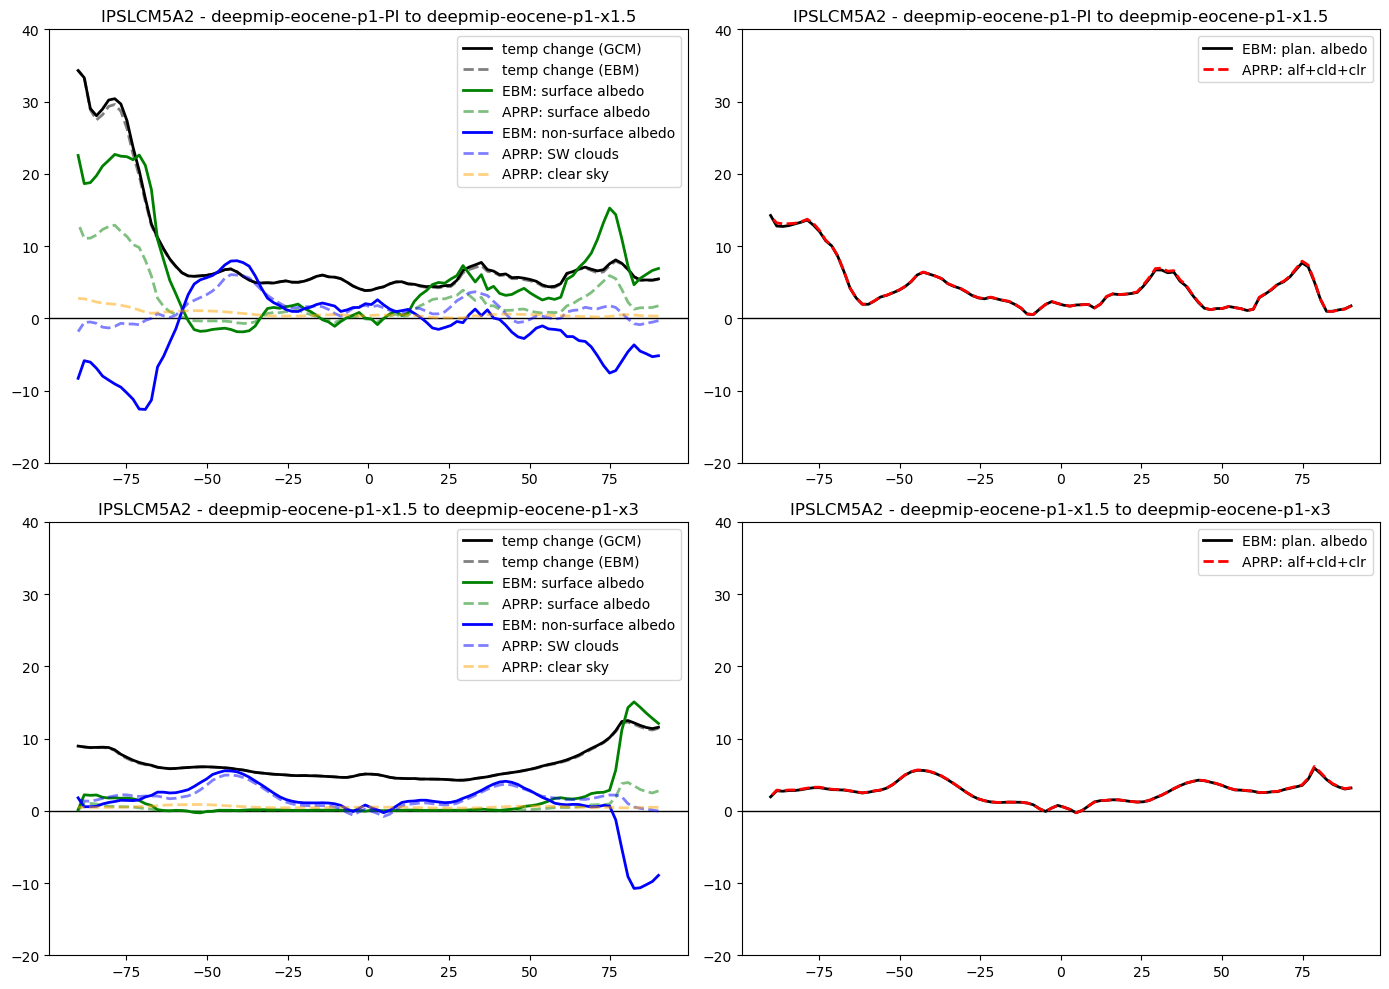

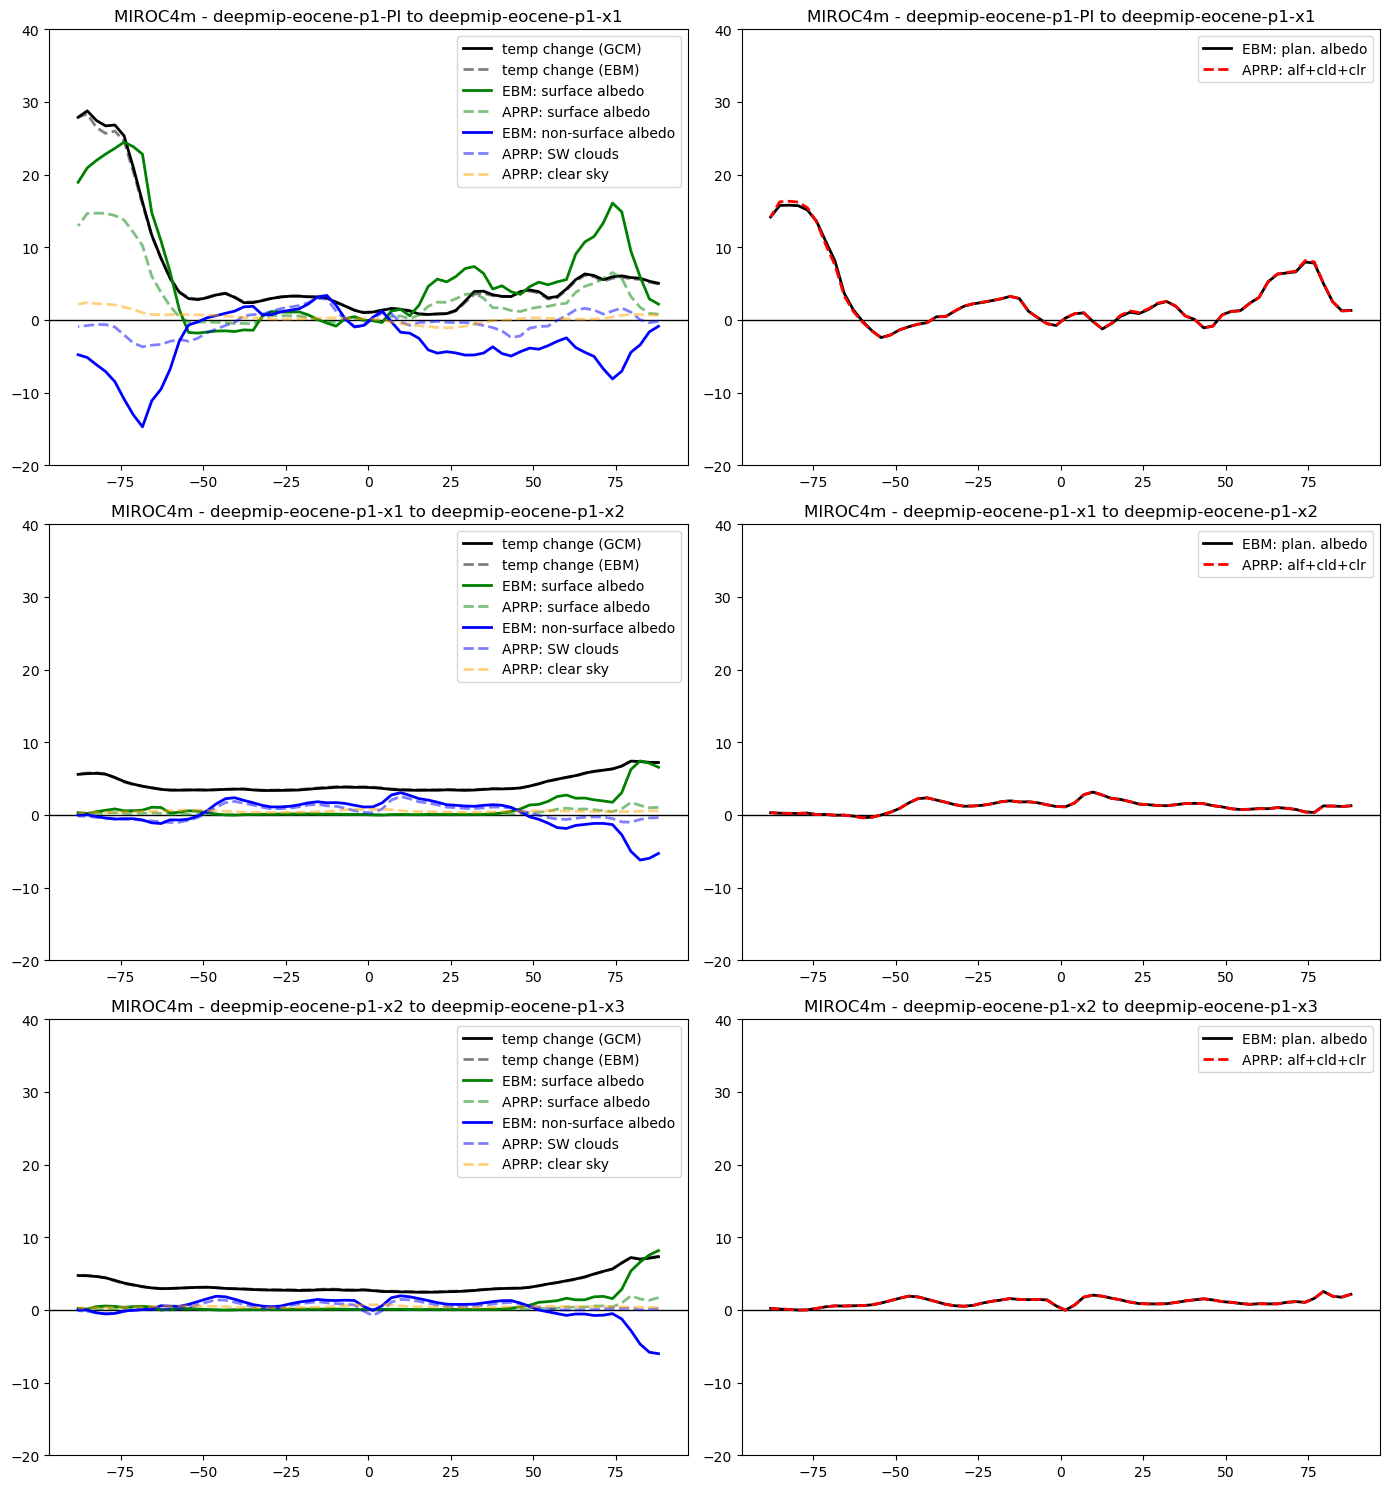

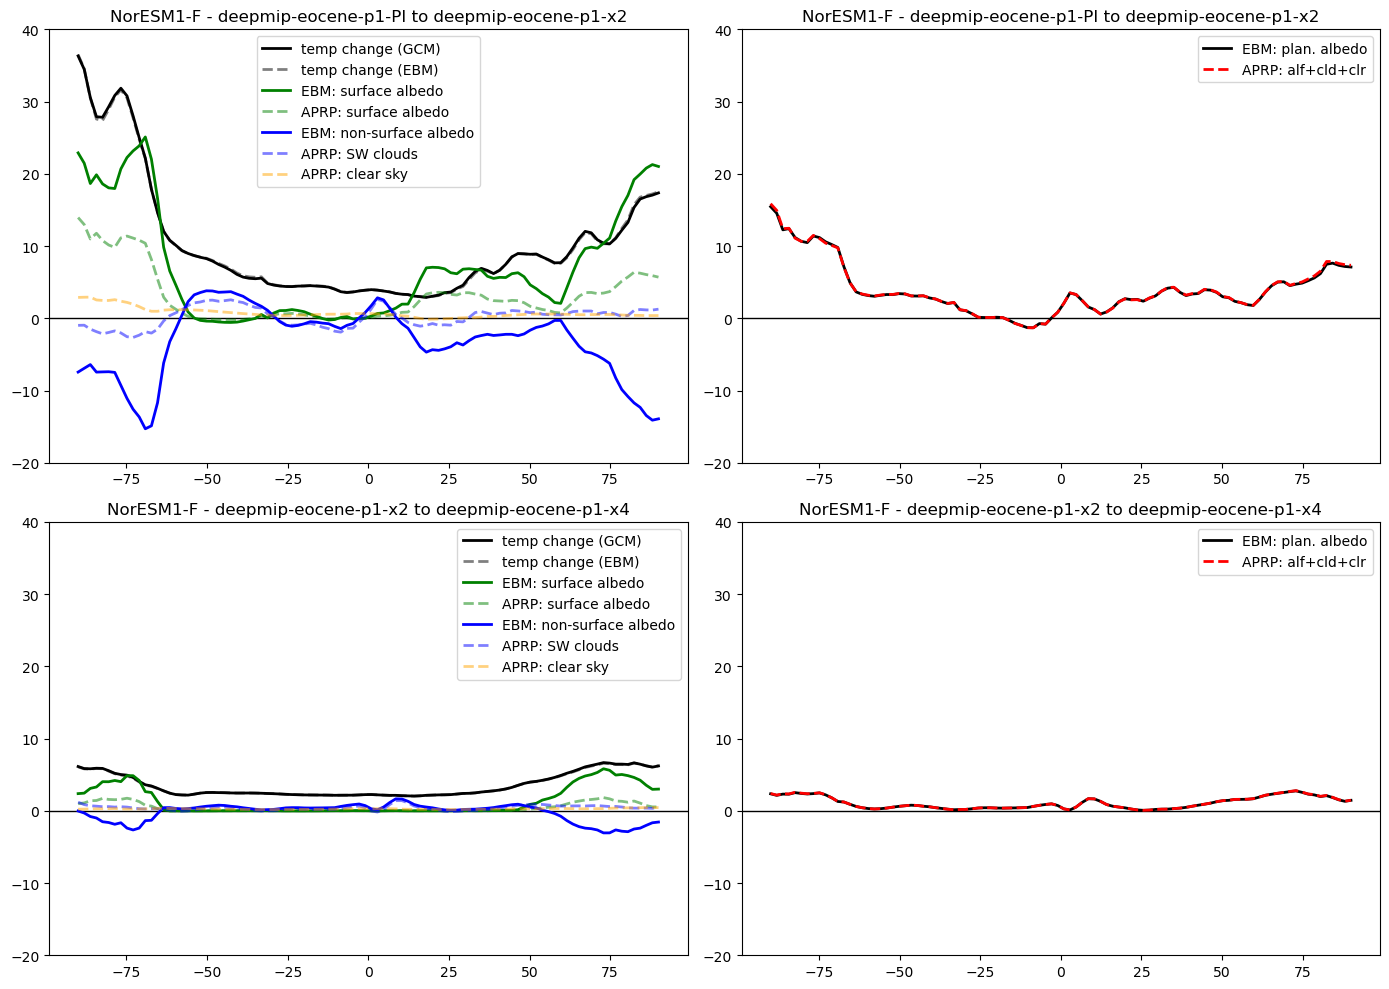

In [9]:
# initialize dictionaries to store global and regional means
GLO_means = {}
NP_means = {}
SP_means = {}
TRO_means = {}
# define variables for regional means
vars_to_process = ['ts1', 'ts2', 'dt_salb', 'dt_aprp_alf', 'dt_swcre', 'dt_aprp_cld', 'dt_aprp_clr', 'dt_palb']

# import EBM results
for model in deepmip_dict.keys():
    ncases = deepmip_dict[model]['ncase'] - 1

    # Initialize dictionaries for this model
    GLO_means[model] = {}
    NP_means[model] = {}
    SP_means[model] = {}
    TRO_means[model] = {}

    # create figure
    fig, axs = plt.subplots(ncases, 2, figsize=(14, 5 * ncases))
    for i in range(ncases):

        scenario = f"{deepmip_dict[model]['contr'][i]}_to_{deepmip_dict[model]['sensi'][i]}"
        GLO_means[model][scenario] = {}
        NP_means[model][scenario] = {}
        SP_means[model][scenario] = {}
        TRO_means[model][scenario] = {}

        ebm_file = model + '.' + deepmip_dict[model]['contr'][i] +'.to.' + deepmip_dict[model]['sensi'][i] + '.ebm.nc'
        ebm      = xr.open_dataset(data_dir + '/deepmip/' + ebm_file, decode_times=False)
        ebm_ym   = ebm.mean('time')

        # plot total change
        axs[i,0].plot(ebm_ym['lat'], ebm_ym['dt_gcm'], label='temp change (GCM)', linewidth=2, color='black', linestyle='solid')
        axs[i,0].plot(ebm_ym['lat'], ebm_ym['dt_ebm'], label='temp change (EBM)', linewidth=2, alpha=0.5, color='black', linestyle='dashed')

        # plot surface albedo
        axs[i,0].plot(ebm_ym['lat'], ebm_ym['dt_salb'], label='EBM: surface albedo', linewidth=2, color='green', linestyle='solid')
        axs[i,0].plot(ebm_ym['lat'], ebm_ym['dt_aprp_alf'], label='APRP: surface albedo', linewidth=2, color='green', alpha=0.5, linestyle='dashed')

        # plot cloud feedbacks
        axs[i,0].plot(ebm_ym['lat'], ebm_ym['dt_swcre'], label='EBM: non-surface albedo', linewidth=2, color='blue', linestyle='solid')
        axs[i,0].plot(ebm_ym['lat'], ebm_ym['dt_aprp_cld'], label='APRP: SW clouds', linewidth=2, color='blue', alpha=0.5, linestyle='dashed')

        # plot clear sky feedbacks
        axs[i,0].plot(ebm_ym['lat'], ebm_ym['dt_aprp_clr'], label='APRP: clear sky', linewidth=2, color='orange', alpha=0.5, linestyle='dashed')

        axs[i,1].plot(ebm_ym['lat'], ebm_ym['dt_palb'], label='EBM: plan. albedo', color='black', linestyle='solid', linewidth=2)
        axs[i,1].plot(ebm_ym['lat'], ebm_ym['dt_aprp_alf'] + ebm_ym['dt_aprp_cld'] + ebm_ym['dt_aprp_clr'], label='APRP: alf+cld+clr', color='red', linestyle='dashed', linewidth=2)

        for p in range(2):
            axs[i,p].set_title(f"{model} - {deepmip_dict[model]['contr'][i]} to {deepmip_dict[model]['sensi'][i]}")
            axs[i,p].axhline(y=0, color='black', linestyle='-', linewidth=1, zorder=0)
            axs[i,p].set_ylim([-20, 40])  
            axs[i,p].legend()

        # calculate global and regional means and save to dictionaries
        for var in vars_to_process:
            ebm_ym_GLO = ebm_ym[var]
            ebm_ym_NP = select_area(ebm_ym[var],60,90)
            ebm_ym_SP = select_area(ebm_ym[var],-90,-60)
            ebm_ym_TRO = select_area(ebm_ym[var],-30,30)

            coslat_GLO = np.cos(np.deg2rad(ebm_ym_GLO.lat))
            coslat_NP = np.cos(np.deg2rad(ebm_ym_NP.lat))
            coslat_SP = np.cos(np.deg2rad(ebm_ym_SP.lat))
            coslat_T = np.cos(np.deg2rad(ebm_ym_TRO.lat))

            GLO_means[model][scenario][var] = ebm_ym_GLO.weighted(coslat_GLO).mean(('lat'))
            NP_means[model][scenario][var] = ebm_ym_NP.weighted(coslat_NP).mean(('lat'))
            SP_means[model][scenario][var] = ebm_ym_SP.weighted(coslat_SP).mean(('lat'))
            TRO_means[model][scenario][var] = ebm_ym_TRO.weighted(coslat_T).mean(('lat'))


    plt.tight_layout()
    # plt.savefig(f"{model}_plots.pdf")  # Save each model's plots as a PDF
    # plt.close()

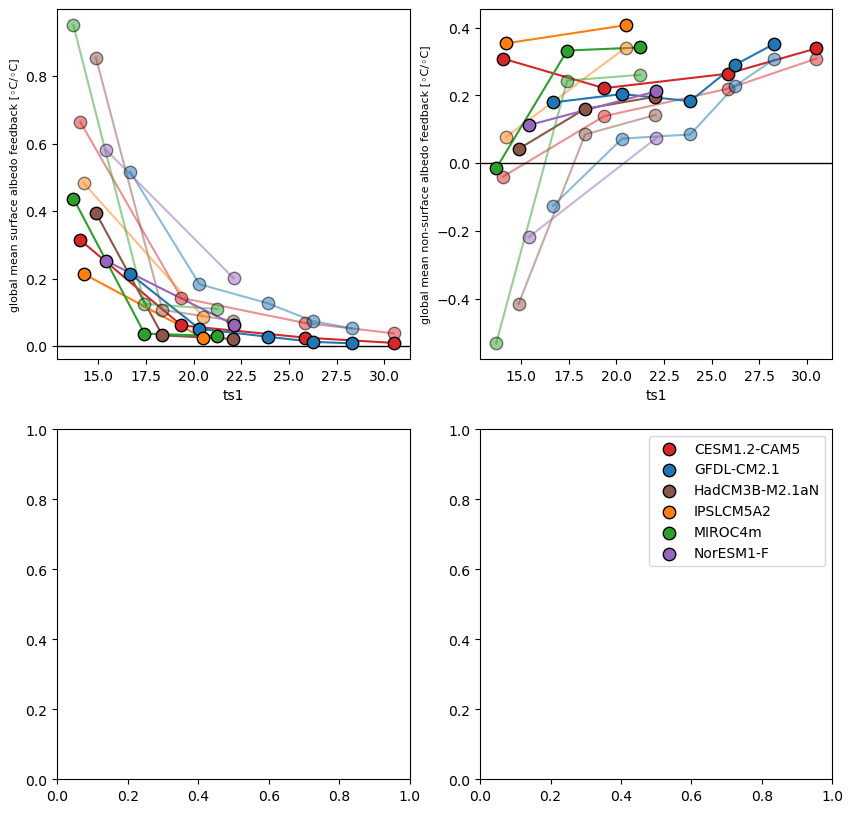

In [39]:
# create scatter plots of globale/regional EBM/APRP comparison
fig, ax = plt.subplots(2,2, figsize=(10, 10))

# Loop through the models and scenarios to plot the scatter points
for model, scenarios in GLO_means.items():
    x_values = []

    # GM surface albedo
    y_values_EBM = []
    y_values_APRP = []
    # EBM results
    for scenario, values in scenarios.items():
        x_value = values['ts1'] - 273.15
        x_values.append(x_value)

        # EBM results
        y_value_EBM = values['dt_salb'] / ( values['ts2'] - values['ts1'] )
        y_values_EBM.append(y_value_EBM)
        ax[0,0].scatter(x_value, 
            y_value_EBM, 
            color=deepmip_dict[model]['pcolor'], 
            label=model, 
            alpha=0.5, 
            edgecolors='black',
            s=80)
        
        # APRP results
        y_value_APRP = values['dt_aprp_alf'] / ( values['ts2'] - values['ts1'] )
        y_values_APRP.append(y_value_APRP)
        ax[0,0].scatter(x_value, 
            y_value_APRP, 
            color=deepmip_dict[model]['pcolor'], 
            label=model, 
            alpha=1.0, 
            edgecolors='black',
            s=80)
        
    # After collecting all points for the model, plot lines connecting them
    ax[0,0].plot(x_values, y_values_EBM, color=deepmip_dict[model]['pcolor'], alpha=0.5, zorder=0)
    ax[0,0].plot(x_values, y_values_APRP, color=deepmip_dict[model]['pcolor'], alpha=1.0, zorder=0)

    x_values = []

    # gm clouds albedo
    y_values_EBM = []
    y_values_APRP = []
    # EBM results
    for scenario, values in scenarios.items():
        x_value = values['ts1'] - 273.15
        x_values.append(x_value)

        # EBM results
        y_value_EBM = values['dt_swcre'] / ( values['ts2'] - values['ts1'] )
        y_values_EBM.append(y_value_EBM)
        ax[0,1].scatter(x_value, 
            y_value_EBM, 
            color=deepmip_dict[model]['pcolor'], 
            label=model, 
            alpha=0.5, 
            edgecolors='black',
            s=80)
        
        # APRP results
        y_value_APRP = (values['dt_aprp_cld'] + values['dt_aprp_clr']) / ( values['ts2'] - values['ts1'] )
        y_values_APRP.append(y_value_APRP)
        ax[0,1].scatter(x_value, 
            y_value_APRP, 
            color=deepmip_dict[model]['pcolor'], 
            label=model, 
            alpha=1.0, 
            edgecolors='black',
            s=80)
        
    # After collecting all points for the model, plot lines connecting them
    ax[0,1].plot(x_values, y_values_EBM, color=deepmip_dict[model]['pcolor'], alpha=0.5, zorder=0)
    ax[0,1].plot(x_values, y_values_APRP, color=deepmip_dict[model]['pcolor'], alpha=1.0, zorder=0)

        
# Adding legend, you might want to handle duplicates
handles, labels = ax[0,0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

ax[0,0].set_xlabel('ts1')
ax[0,0].set_ylabel('global mean surface albedo feedback [◦C/◦C]',fontsize=8)
ax[0,0].axhline(y=0, color='black', linestyle='-', linewidth=1, zorder=0)

ax[0,1].set_xlabel('ts1')
ax[0,1].set_ylabel('global mean non-surface albedo feedback [◦C/◦C]',fontsize=8)
ax[0,1].axhline(y=0, color='black', linestyle='-', linewidth=1, zorder=0)

plt.show()